# Нейросети в задачих обработки текстов

Основано на коде из курса [Глубинное обучение ФКН](https://github.com/aosokin/dl_cshse_ami).

**Разработчик: Алексей Озерин, Ирина Сапарина**

# Генерация коротких текстов с помощью RNN и Transformer


Генерировать тексты можно как с помощью RNN, так и с помощью Transformer, предсказывая следующий символ последовательности по предыдущим. Мы будем использовать архитектуру Transformer.

В этом задании предлагается написать и проучить на небольшом датасете имен генеративную модель на основе символов.

In [1]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, Sampler
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

import datetime
import os
from copy import deepcopy
from collections import defaultdict, OrderedDict

random.seed(2021)
np.random.seed(2021)
torch.manual_seed(2021)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2021)

В файле `names` находится ~8k имен на латинице.

Модель будет получать на вход имя `Amandy` и выдавать его же, только со сдвигом: `mandy `.

Чтобы сеть училась генерировать заглавные буквы, добавим в начало специальный токен `_`.

Также нам потребуется правило для останова генерации (это может быть просто ограничение на количество шагов). С другой стороны, можно добавить в конец каждого примера обучающей выборки специальный `<EOS>` токен. В данном случае обозначим его `#`:

```
_Amandy --> Amandy#
```

Можно прекращать генерацию при досрочном выпадании `<EOS>`.

Для генерации на каждом шаге будем подавать на вход букву, предсказанную на предыдущем.



In [2]:
import os
start_token = "_"
eos = '#'

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print('There are {} names: '.format(len(names)))
for x in names[::1000]:
    print(x)

There are 7578 names: 
_Wolf#
_Lolly#
_Amy#
_Grete#
_Reuven#
_Nanice#
_Nikoletta#
_Olenka#


# Подготовка и знакомство с данными
**(0.1 балла)**

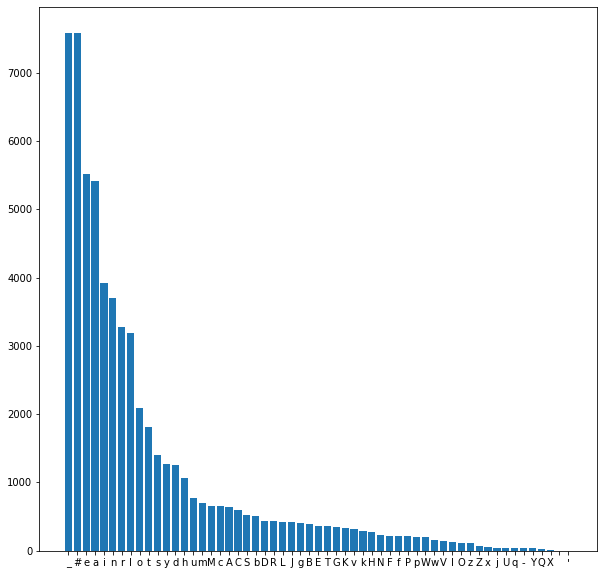

In [3]:
# TODO: постройте частоты употреблений букв
dic = defaultdict(int)
for name in names:
    for letter in name:
        dic[letter] +=1
        
ordered = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10,10))
plt.bar(x=ordered.keys(), height=ordered.values())
plt.show()
# HINT: для графика возьмите plt.bar

max length = 17


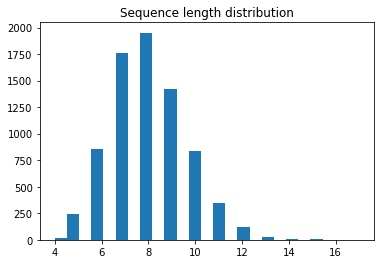

In [4]:
# в датасете есть слова с разными длинами
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [5]:
names[:10]

['_Wolf#',
 '_Yancey#',
 '_Willow#',
 '_Zachariah#',
 '_Mady#',
 '_Maynard#',
 '_Ferguson#',
 '_Rosana#',
 '_Tami#',
 '_Stu#']

In [6]:
# TODO: отберите уникальные токены и заполните два словаря для конвертации токенов <-> индексы
# сделайте так, чтобы pad_token имел номер 0
    
tokens = ordered.keys()
    
tok2id = {tok: i for i, tok in enumerate(tokens)}
id2tok = {i: tok for i, tok in enumerate(tokens)}

n_tokens = len(tokens)
print ('There are {} tokens'.format(n_tokens))

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are 57 tokens
Vocabular: _#eainrlotsydhumMcACSbDRLJgBETGKvkHNFfPpWwVIOzZxjUq-YQX '


## Работа с последовательностями произвольной длины в pytorch

Нам нужно уметь генерировать батчи тензоров `[bs, 1, seq_len]`.
Но в нашем датасете семплы разной длины:

- мы могли бы подрезать все до минимальной
- паддить до максимальной
- выбрать какую-то среднюю длину

**(0.1 балла)** Разбейте датасет на train и validate:

In [7]:
#!g1.1
# сделаем датасет выдающий закодированные имена:
class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, item):
        entry = self.names[item]
        lst = []
        for letter in entry:
            lst.append(tok2id[letter])
        while len(lst) < 10:
            lst.append(tok2id[' '])
        entry = torch.tensor(lst[:10])
        return dict(
            encoded=entry,
        )

# Вот тут я вообще ничего не понял, по идеи tok2id - это словарь, в котором токены переводятся в индексы. Но словари так не вызываются
# получаю естественно ошибку TypeError: 'dict' object is not callable
# поскольку непонятна изначальная задумка, то сделаю по-своему и предобработку имен сделаю в датасете.

# encoded = []
# for entry in tqdm(names):
#     encoded.append(tok2id(entry))


def train_val_split(names, train_size=0.85):
    train = np.random.choice(names, size=int(train_size * len(names)), replace=False)
    val = np.setdiff1d(np.array(names), train)
    return train, val

train_names, val_names = train_val_split(names)
    
trainset = NamesDataset(train_names)
valset = NamesDataset(val_names)

Давайте соберем наивный DataLoader и посмотрим как он делает батчи:


In [8]:
#!g1.1
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
it = iter(trainloader)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: it
  warnings.warn(message)


In [9]:
#!g1.1
batch = next(it)['encoded']
batch

tensor([[ 0, 43, 10,  4, 12,  8,  6,  2,  1, 55],
        [ 0, 34,  3, 10, 10,  3,  5,  1, 55, 55],
        [ 0, 25, 11,  8,  9,  4,  1, 55, 55, 55],
        [ 0, 18, 15,  3,  5, 12,  4,  2,  1, 55],
        [ 0, 40,  4,  7,  9,  1, 55, 55, 55, 55],
        [ 0, 40,  2, 11,  7,  4,  5,  1, 55, 55],
        [ 0, 23,  3, 11, 15, 14,  5, 12,  8,  1],
        [ 0, 24,  8,  6,  4,  1, 55, 55, 55, 55]])

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: it
  warnings.warn(message)


В моем случае, результат запуска был таков:
```
[tensor([1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([ 6,  7,  6, 15,  5,  6,  5, 62]),
 tensor([ 48,  34,  83,   7,  32, 221,  22,  43]),
 tensor([  5, 143,  37,  36, 129,  12,  11,  66]),
 tensor([  73, 1258,  279,    8,    6,  555,   41,   10]),
 tensor([  8, 140,   8, 628,  20,  96,  13, 270]),
 tensor([  47,    4,   15,   18,   55,  269,    6, 1287]),
 tensor([ 58,   2,  13, 140, 193, 140, 171, 140])]
```

Какие странности здесь видны?
1. Это не тензор, а список тензоров. Соответственно при итерировании по нулевой размерности (`batch[i, :]`) мы будем получать не i-пример, а i-токены для всех примеров в батче. Это не проблема, но отличается от ожидаемого поведения.
2. На `<EOS>` (2) оканчивается только один пример, остальные подрезаны под его длину. И вот это уже проблема.

Мы бы хотели западдить все примеры до длины максимального в батче. 
Но на этапе подготовки примера (в функции `__getitem__`) мы не знаем соседей по батчу!
Для того чтобы поменять логику склейки батчей нам понадобиться написать свою функцию `collate_fn` в конструкторе DataLoader:

```
def collate_fn(samples):
    # samples -- список семплов-словарей
    <...>
    return batch
```

**(0.1 балл)** Напишите функцию `collate_fn`, которая _правильно_ паддит names-последовательности и объединяет их в батчи, где `batch[i, :]` выдает токены для `i`-примера.

Ожидаемый выход (для последовательности с левым паддингом):

```
tensor([[   1,   10, 3429,  405,  113,  676,   10, 1031,  140,    4,    2],
        [   0,    1,   57,   18,   23,   19,   61,    7,  140,    4,    2],
        [   0,    0,    0,    1,   16,   17, 1131,  416,  140,    4,    2],
        [   0,    0,    0,    1,   13,  465,   75,  197,  140,    4,    2],
        [   0,    0,    0,    1,    6,  302,   13,  144,  140,    4,    2],
        [   0,    1,    6,   59,  205,  167,    8,   15,  140,    4,    2],
        [   0,    0,    0,    0,    1,    6,   14,  678,  140,    4,    2],
        [   0,    0,    1,    5,   29,   67,    6,   14,  140,    4,    2]])
```

В моем случае нет необходимости в collate_fn, все уже сделано в датасете. Однако, я использую правый паддинг и надеюсь это не проблема

In [10]:
#!g1.1
# def collate_fn(samples):
#     # <your code>
#     return dict(
#         encoded=...
#     )


trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
it = iter(trainloader)
next(it)['encoded']

tensor([[ 0, 34,  3, 39, 39, 11,  1, 55, 55, 55],
        [ 0, 23,  4, 17, 13, 11,  1, 55, 55, 55],
        [ 0, 31,  4,  1, 55, 55, 55, 55, 55, 55],
        [ 0, 28,  7, 21,  2,  6,  9,  1, 55, 55],
        [ 0, 36,  6,  3,  5,  1, 55, 55, 55, 55],
        [ 0, 44,  6,  3,  7,  2,  2,  1, 55, 55],
        [ 0, 53, 14,  4,  5,  5,  1, 55, 55, 55],
        [ 0, 25, 14,  3,  5,  3,  1, 55, 55, 55]])

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: it
  warnings.warn(message)


# Char-RNN для имен (0.2 балла)

Вам нужно написать сеть, кодирующую номера входных символов с помощью таблицы Embeddings. 
Получившиеся тензоры пропустить через RNN ячейку, затем преобразовать в логиты для предсказания номера нового символа.

In [11]:
#!g1.1
# NB: обратите внимание на порядок осей при вызове forward
# http://pytorch.org/docs/master/nn.html#recurrent-layers

# Сделайте возможность выбора типа ячейки, RNN, GRU или LSTM
# TODO: заполните пропуски. Функция forward будет вызываться на каждый шаг нами

class NameRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, cell="lstm", n_layers=1):
        super(NameRNN, self).__init__()
        # добавьте возможность выбрать тип ячейки RNN/LSTM
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell = cell
        self.n_layers = n_layers
        
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

        if self.cell == 'rnn':
            self.model = nn.RNN(hidden_size, hidden_size, n_layers)
        elif self.cell == 'lstm':
            self.model = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif self.cell == 'gru':
            self.model = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, input, hidden):
        embeddings = self.embeddings(input).view(self.n_layers, input.shape[0], -1)
        output, hidden = self.model(embeddings, hidden)
        out = self.linear(output).view(input.shape[0], -1)
        return out, hidden

    def init_hidden(self, batch_size):
        tens = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        if torch.cuda.is_available():
            tens = tens.cuda()
        if self.cell == "lstm":
            return tens, tens
        return tens
    
    def compute_all(self, batch):
        x = batch['encoded']
        hidden = self.init_hidden(x.shape[0])
        loss, acc = 0, 0
        for i in range(x.shape[1]-1):
            out, h = self.forward(x[:, i], hidden)
            loss += F.cross_entropy(out, x[:, i+1])
            acc += (out.argmax(axis=1) == x[:, i+1]).float().mean().cpu().numpy()
        metrics = dict(acc=acc/x.shape[0])
        return loss, metrics

# Натренируйте модель (0.2 балла)

Возьмите трейнер с предыдущих занятий, натренируйте модель

In [15]:
#!g1.1
class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 train_sampler: Sampler = None,
                 val_sampler: Sampler = None,
                 tboard_log_dir: str = "results/",
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.train_sampler = train_sampler
        self.val_sampler = val_sampler

        self.device = 'cuda'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        
        self.train_writer = SummaryWriter(log_dir=tboard_log_dir + "train/" \
                                          + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
        self.val_writer = SummaryWriter(log_dir=tboard_log_dir + "val/" \
                                        + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer
        
        if self.train_sampler is None:
            shuffle=True
        else:
            shuffle=False
        train_loader = DataLoader(self.train_dataset, pin_memory=True, shuffle=shuffle, batch_size=self.batch_size, sampler=self.train_sampler)
        val_loader = DataLoader(self.val_dataset, pin_memory=True, shuffle=False, batch_size=self.batch_size, sampler=self.val_sampler)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                for k, v in details.items():
                    self.train_writer.add_scalar(k, v, global_step=self.global_step)
            
                self.train_writer.add_scalar(f'loss', loss, global_step=self.global_step)
                self.global_step += 1
    

            model.eval()
            val_losses, val_metrics_list = [], []
                
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())
                                  
            val_loss = np.mean(val_losses)
            val_metrics = np.mean(val_metrics_list)

            self.val_writer.add_scalar(f'loss', val_loss, global_step=self.global_step)
            self.val_writer.add_scalar(f'metrics', val_metrics, global_step=self.global_step)

            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss
                                  
            print('[{} epoch] - loss: {}, metric: {}'.format(epoch+1, round(val_loss, 5), round(val_metrics, 5)))
            
    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        
        train_loader = DataLoader(self.train_dataset, pin_memory=True, shuffle=False, batch_size=self.batch_size, sampler=self.train_sampler)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)
            
        for k, v in logs.items():
            for i in range(len(v)):
                self.train_writer.add_scalar(k, v[i], global_step=self.global_step)
                self.global_step += 1

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

        return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

Натренируем разные модели, та, которая покажет наименьший лосс, ту и возьмем в следующих заданиях.

In [16]:
#!g1.1
RNN = NameRNN(len(tokens), 500, len(tokens), cell='rnn')
opt = torch.optim.Adam(RNN.parameters(), lr=1e-4)
trainer = Trainer(model = RNN, optimizer = opt, train_dataset = trainset, 
                  val_dataset = valset, batch_size=16)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [17]:
#!g1.1
trainer.train(5)


[1 epoch] - loss: 17.09869, metric: 0.26666




[2 epoch] - loss: 16.73139, metric: 0.26622



[3 epoch] - loss: 16.63686, metric: 0.26785



[4 epoch] - loss: 16.60099, metric: 0.26666



[5 epoch] - loss: 16.58045, metric: 0.26823


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [18]:
#!g1.1
LSTM = NameRNN(len(tokens), 500, len(tokens), cell='lstm')
opt = torch.optim.Adam(LSTM.parameters(), lr=1e-4)
trainer = Trainer(model = LSTM, optimizer = opt, train_dataset = trainset, 
                  val_dataset = valset, batch_size=16)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [19]:
#!g1.1
trainer.train(5)


[1 epoch] - loss: 17.46073, metric: 0.26584



[2 epoch] - loss: 16.85908, metric: 0.26736



[3 epoch] - loss: 16.68001, metric: 0.26769



[4 epoch] - loss: 16.61956, metric: 0.26666



[5 epoch] - loss: 16.57081, metric: 0.26617


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [20]:
#!g1.1
GRU = NameRNN(len(tokens), 500, len(tokens), cell='gru')
opt = torch.optim.Adam(GRU.parameters(), lr=1e-4)
trainer = Trainer(model = GRU, optimizer = opt, train_dataset = trainset, 
                  val_dataset = valset, batch_size=16)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [21]:
#!g1.1
trainer.train(5)


[1 epoch] - loss: 17.19627, metric: 0.26617



[2 epoch] - loss: 16.76662, metric: 0.26503



[3 epoch] - loss: 16.64545, metric: 0.2672



[4 epoch] - loss: 16.59138, metric: 0.26921



[5 epoch] - loss: 16.57261, metric: 0.26812


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


Дополнительно натренеруем "лучшую" модель. (Они оказались +- одинаковыми, остановимся на RNN)

In [22]:
#!g1.1
opt = torch.optim.Adam(RNN.parameters(), lr=1e-4)
trainer = Trainer(model = RNN, optimizer = opt, train_dataset = trainset, 
                  val_dataset = valset, batch_size=16)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [23]:
#!g1.1
trainer.train(10)


[1 epoch] - loss: 16.5441, metric: 0.2672



[2 epoch] - loss: 16.57162, metric: 0.26774



[3 epoch] - loss: 16.5466, metric: 0.26769



[4 epoch] - loss: 16.54046, metric: 0.2685



[5 epoch] - loss: 16.55406, metric: 0.26872



[6 epoch] - loss: 16.55259, metric: 0.26682



[7 epoch] - loss: 16.51213, metric: 0.26666




[8 epoch] - loss: 16.54277, metric: 0.26617



[9 epoch] - loss: 16.53426, metric: 0.26617



[10 epoch] - loss: 16.53237, metric: 0.26454


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


# Генерация по argmax (0.2 балла)

In [24]:
#!g1.1
# Напишите функцию генерации продолжения строки
def pick_by_argmax(logits):
    return logits.cpu().argmax(axis=1).numpy()[0]

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix="_"):
    # TODO: сначала подайте на вход префикс
    # нас интересует последний output, чтобы получить первое предсказание
    hidden = model.init_hidden(1)
    lst = []
    for letter in prefix:
        lst.append(tok2id[letter])
    prefix_tensor = torch.tensor(lst).view(-1, 1).cuda()
    for i in prefix_tensor:
        out, hidden = model.forward(i, hidden)
    # TODO: затем сгенерируйте несколько последующих символов
    # outs -- это массив с номерами токенов
    outs = [pick_by_argmax(out)]
    ids = out.argmax(axis=1)
    for i in range(8): # в зависимости от максимальной длины имени, моя модель видила имена максю длины - 10
        out, hidden = model.forward(ids, hidden)
        outs.append(pick_by_argmax(out))
        ids = out.argmax(axis=1)
    
    print(prefix + '|'+ ids2string(outs))
    
gen_continuation(RNN, "_Ku")

_Ku|rin#     


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


# Генерация с семплированием (0.2 балла)

Обычный софтмакс 
$$p_i = \frac{\exp (x_i)}{\sum \exp (x_j)}$$
можно модернизировать с помощью температуры:
$$p_i = \frac{\exp (x_i / T)}{\sum \exp (x_j / T)}$$

Это позволит плавно переходить от выбора наиболее вероятного элемента ($T << 1$) до практически равновероятного ($T >> 1$)


In [25]:
#!g1.1
# Напишите функцию генерации батчами с семплированием из распределения и температурой
def batch2string(ids, prefix):
    # модифицируйте ids2string для работы с батчами
    return '\n'.join([prefix + ''.join(id2tok[_] for _ in x) for x in ids])

def pick_by_distribution(logits, temperature):
    # превратите логиты в распределение
    # затем семлируйте из него batch примеров
    logits=logits.cpu()
    distr = torch.exp(logits / temperature) / torch.sum(torch.exp(logits / temperature))
    return np.random.choice(range(len(distr)), size=1, p=distr.detach().numpy())[0]


def gen_continuation_temp(model, prefix="_", temperature=1.0, n=10):
    # аналогично, сначала подайте на вход префикс
    # нас интересует последний output, чтобы получить первое предсказание
    hidden = model.init_hidden(n)
    lst = []
    for letter in prefix:
        lst.append(tok2id[letter])
    prefix_tensor = torch.tensor(lst).view(-1, 1) 
    prefix_tensor = prefix_tensor.repeat(1, n).cuda()
    for i in prefix_tensor:
        out, hidden = model.forward(i, hidden)
    # затем, сгенерируйте n последующих символов
    # в outs положите матрицу номеров токенов и отобразите ее
    outs = []
    for i in range(n):
        outs.append([pick_by_distribution(out[i], temperature)])
    ids = torch.tensor(outs).cuda()
    for i in range(8): # в зависимости от максимальной длины имени, моя модель видила имена максю длины - 10
        out, hidden = model.forward(ids, hidden)
        for j in range(n):
            outs[j].append(pick_by_distribution(out[j], temperature))
        ids = torch.tensor(outs)[:, i + 1].cuda()
    
    print(batch2string(outs, prefix + '|'))
    
gen_continuation_temp(RNN, prefix="_An", temperature=0.5, n=10)

_An|donne#   
_An|ery#     
_An|#        
_An|nia#     
_An|a#       
_An|ale#     
_An|#        
_An|#        
_An|#        
_An|in#      


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


# Char-Transformer для имен (1.0 дополнительные баллы)

Вам нужно написать сеть, кодирующую входные символы и их позиции с помощью таблиц Embeddings. 
Получившиеся тензоры пропустить через `TransformerEncoder`, затем преобразовать в логиты для предсказания новых символов.

Transformer может обрабатывать сразу всю последовательность за один проход. Для того, чтобы у модели не было возможности "заглянуть в будущее", то есть использовать информацию о впреди идущих символах, необходимо сгенерировать маску. `TransformerEncoder` должен принимать на вход последовательность символов и маску.    
![Transformer](https://drive.google.com/uc?export=view&id=1gXILzT3mGgc0mGlvqY-6R4bGs3Lx2YxM)
Картинка из [illustrated transformer](http://jalammar.github.io/illustrated-transformer/)

In [ ]:
# TODO: заполните пропуски

class NameTransformer(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=2, n_head=2, dropout=0.1):
        super(NameTransformer, self).__init__()
        self.vocab_size = vocab_size

        <your code>

    def _generate_square_subsequent_mask(self, seq_len):
        # TODO: сгенерируйте маску размера seq_len x seq_len
        # если во время кодирования i-го символа j-й символ доступен, 
        # то (i,j) элемент маски равен 0, иначе -inf
        
        <your code>

        return mask
        
    def forward(self, input):

        <your code>

        return output

# Натренируйте модель

И убедитесь, что она работает адекватно